In [223]:
import openfermion
import openfermionpyscf
from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.ops import FermionOperator, QubitOperator
from openfermion.transforms import jordan_wigner, bravyi_kitaev
from openfermion.transforms import get_fermion_operator
from openfermion.circuits import (uccsd_singlet_get_packed_amplitudes,
                               uccsd_singlet_generator, uccsd_generator,
                               uccsd_convert_amplitude_format)
import numpy as np
import cs_vqe as c
import itertools
import qubit_conversion as q_conv

singlet_bool = True # Set general UCCSD or singlet UCCSD.

bond_len = 0.772#1.45
atom_1 = 'He'
atom_2 = 'H'
basis = 'sto3g'
multiplicity = 1
charge = 1

coordinate_1 = (0.0, 0.0, 0.0)
coordinate_2 = (0.0, 0.0, bond_len)
geometry = [(atom_1, coordinate_1), (atom_2, coordinate_2)]

molecule_data = MolecularData(geometry, basis, multiplicity, charge, description='Test')
#molecule.load()

# Set calculation parameters.
run_scf = 1
run_mp2 = 1
run_cisd = 0
run_ccsd = 0
run_fci = 1
delete_input = True
delete_output = True

# Run pyscf.
molecule = run_pyscf(molecule_data,
                     run_scf=run_scf,
                     run_mp2=run_mp2,
                     run_cisd=run_cisd,
                     run_ccsd=run_ccsd,
                     run_fci=run_fci)

#molecule.load()
#print(molecule)

ham = get_fermion_operator(molecule.get_molecular_hamiltonian())
ham_q = jordan_wigner(ham)
print('Hamiltonian:', '\n', ham_q, '\n')

scf = True      # Hartree-Fock.
mp2 = True      # Moller-Plesset 2.
cisd = True     # Configuration interaction singles and doubles.
ccsd = True     # Coupled cluster singles and doubles.
fci = True      # Full configuration interaction.

calculated_molecule = run_pyscf(molecule_data, scf, mp2, cisd, ccsd, fci)

if ccsd:
    ccsd_single_amps = calculated_molecule.ccsd_single_amps
    ccsd_double_amps = calculated_molecule.ccsd_double_amps

num_electrons = calculated_molecule.n_electrons
num_qubits = 2*calculated_molecule.n_orbitals

if singlet_bool:
    # Get singlet UCCSD generator.
    packed_amps = uccsd_singlet_get_packed_amplitudes(ccsd_single_amps,  ccsd_double_amps, num_qubits, num_electrons)
    ucc_sing = uccsd_singlet_generator(packed_amps, num_qubits, num_electrons)
    #print(ucc_sing)

else:
    # Get general UCCSD operator.
    ucc_op = uccsd_generator(ccsd_single_amps, ccsd_double_amps)
    #print(ucc_op)
    
ucc_q = jordan_wigner(ucc_sing)
print('UCCSD ansatz:', '\n', ucc_q)

Hamiltonian: 
 (-1.5419759528969692+0j) [] +
(-0.03640948355953764+0j) [X0 X1 Y2 Y3] +
(0.03640948355953764+0j) [X0 Y1 Y2 X3] +
(0.05246557037552685+0j) [X0 Z1 X2] +
(-0.009234661837974558+0j) [X0 Z1 X2 Z3] +
(0.04322997146404521+0j) [X0 X2] +
(0.03640948355953764+0j) [Y0 X1 X2 Y3] +
(-0.03640948355953764+0j) [Y0 Y1 X2 X3] +
(0.05246557037552685+0j) [Y0 Z1 Y2] +
(-0.009234661837974558+0j) [Y0 Z1 Y2 Z3] +
(0.04322997146404521+0j) [Y0 Y2] +
(0.7589136134172096+0j) [Z0] +
(0.04322997146404521+0j) [Z0 X1 Z2 X3] +
(0.04322997146404521+0j) [Z0 Y1 Z2 Y3] +
(0.23578727153769516+0j) [Z0 Z1] +
(0.12887693985157755+0j) [Z0 Z2] +
(0.1652864234111152+0j) [Z0 Z3] +
(0.05246557037552685+0j) [X1 Z2 X3] +
(-0.009234661837974558+0j) [X1 X3] +
(0.05246557037552685+0j) [Y1 Z2 Y3] +
(-0.009234661837974558+0j) [Y1 Y3] +
(0.7589136134172096+0j) [Z1] +
(0.1652864234111152+0j) [Z1 Z2] +
(0.12887693985157755+0j) [Z1 Z3] +
(0.19140054473500764+0j) [Z2] +
(0.18815905542064587+0j) [Z2 Z3] +
(0.19140054473500764+0j

In [196]:
ham = q_conv.QubitOperator_to_dict(ham_q, num_qubits)
anz_terms = list((q_conv.QubitOperator_to_dict(ucc_q, num_qubits)).keys())

In [197]:
terms_noncon = c.greedy_dfs(ham, 1, criterion='weight')[-1]
ham_noncon = {t:ham[t] for t in terms_noncon}
ham_noncon

{'IIII': (-1.5419759528969692+0j),
 'ZIII': (0.7589136134172096+0j),
 'IZII': (0.7589136134172096+0j),
 'ZZII': (0.23578727153769516+0j),
 'IIZI': (0.19140054473500764+0j),
 'IIIZ': (0.19140054473500764+0j),
 'IIZZ': (0.18815905542064587+0j),
 'ZIIZ': (0.1652864234111152+0j),
 'IZZI': (0.1652864234111152+0j),
 'ZIZI': (0.12887693985157755+0j),
 'IZIZ': (0.12887693985157755+0j),
 'YZYI': (0.05246557037552685+0j),
 'XZXI': (0.05246557037552685+0j),
 'YIYI': (0.04322997146404521+0j),
 'XIXI': (0.04322997146404521+0j),
 'YZYZ': (-0.009234661837974558+0j),
 'XZXZ': (-0.009234661837974558+0j)}

In [198]:
terms_context = list(ham.keys() - terms_noncon)
ham_context = {t:ham[t] for t in terms_context}
ham_context

{'ZXZX': (0.04322997146404521+0j),
 'YXXY': (0.03640948355953764+0j),
 'IXIX': (-0.009234661837974558+0j),
 'XYYX': (0.03640948355953764+0j),
 'ZYZY': (0.04322997146404521+0j),
 'IYZY': (0.05246557037552685+0j),
 'IXZX': (0.05246557037552685+0j),
 'YYXX': (-0.03640948355953764+0j),
 'IYIY': (-0.009234661837974558+0j),
 'XXYY': (-0.03640948355953764+0j)}

In [199]:
c.contextualQ_ham(ham_context)

False

In [200]:
model = c.quasi_model(ham_noncon)
fn_form = c.energy_function_form(ham_noncon, model)
gs_noncon = c.find_gs_noncon(ham_noncon)
gs_noncon_energy = gs_noncon[0]
ep_state = gs_noncon[1]

In [201]:
#model_c = c.quasi_model(ham_context)
#fn_form_c = c.energy_function_form(ham_context, model_c)
#gs_noncon_c = c.find_gs_noncon(ham_context)
#gs_noncon_energy_c = gs_noncon_c[0]
#ep_state_c = gs_noncon_c[1]

#print(gs_noncon_energy_c)
#gs_noncon_c

In [202]:
from qiskit.aqua.algorithms import NumPyEigensolver

order = [0,1,2,3,4,5,6,7]
print(c.contextual_subspace_approximations(ham,model,fn_form,ep_state,order))

result = NumPyEigensolver(q_conv.dict_to_WeightedPauliOperator(ham)).run()
exact_energy = np.real(result.eigenvalues)

print(exact_energy)

[-3.0134857192955558, -3.0134857192955553, -3.013485719295555, -3.0134857192955553, -3.0134857192955584, -3.013485719295556, -3.0134857192955606, -3.013485719295562, -3.0134857192955566]
[-3.01348572]


In [203]:
gs_noncon_energy, ep_state

(-3.0134857192955553,
 [[-1, -1, -1], [-0.07087650179757096, -0.9974850983813939]])

In [204]:
def ontic_prob(ep_state, ontic_state):
    
    if ep_state[0] != ontic_state[0]:
        return 0
    
    else:
        prod = 1
        for index, r in enumerate(ep_state[1]):
            f = 1/2 * abs(r + ontic_state[1][index])
            prod *= f
        
        return prod    

def epistemic_dist(ep_state):
    size_G = len(ep_state[0])
    size_Ci = len(ep_state[1])
    size_R = size_G + size_Ci
    
    ep_prob = {}
    
    ontic_states = list(itertools.product([1, -1], repeat=size_R))
    
    for o in ontic_states:
        o_state = [list(o[0:size_G]), list(o[size_G:size_R])]
        o_prob = ontic_prob(ep_state, o_state)
        
        if o_prob != 0:
            ep_prob[o] = o_prob
    
    return ep_prob

In [205]:
epistemic_dist(ep_state)

{(-1, -1, -1, 1, 1): 0.0005841635473785683,
 (-1, -1, -1, 1, -1): 0.46397758555383595,
 (-1, -1, -1, -1, 1): 0.000673287261924494,
 (-1, -1, -1, -1, -1): 0.534764963636861}

In [206]:
p = ep_state[1][0]**2 #p
p2 = ep_state[1][1]**2 #1-p
p, p2, p+p2

(0.00502347850706108, 0.994976521492939, 1.0)

In [207]:
t_vals = [-np.arctan((pm1 + np.sqrt(1-p))/np.sqrt(p)) for pm1 in [+1, -1]]
t_vals

[-1.5353283380740328, 0.035467988720863146]

In [208]:
def bin_to_int(bin_str):
    bits = [int(b) for b in bin_str]
    for index, b in enumerate(bits):
        bits[index] = b * 2 ** (len(bits)-index-1)
    return sum(bits)

initial_state = [0 for i in range(2**4)]
initial_state[bin_to_int('1101')] = np.sin(t_vals[1])
initial_state[bin_to_int('0111')] = np.cos(t_vals[1])
initial_state

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.9993710768231673,
 0,
 0,
 0,
 0,
 0,
 0.03546055286234321,
 0,
 0]

In [209]:
from qiskit import QuantumCircuit
from qiskit.extensions import Initialize

anz = QuantumCircuit(4) # We are redefining qc
anz.initialize(initial_state)
anz.draw()

┌───────────────────────────────────────────────────────────┐
q_0: ┤0                                                          ├
     │                                                           │
q_1: ┤1                                                          ├
     │  initialize(0,0,0,0,0,0,0,0.99937,0,0,0,0,0,0.035461,0,0) │
q_2: ┤2                                                          ├
     │                                                           │
q_3: ┤3                                                          ├
     └───────────────────────────────────────────────────────────┘

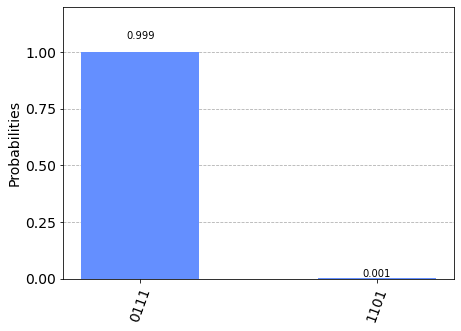

In [210]:
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
from math import sqrt, pi

svsim = Aer.get_backend('statevector_simulator') # Tell Qiskit how to simulate our circuit
qobj = assemble(anz)
result = svsim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [211]:
import cs_vqe_ansatz as c_anz
from qiskit.circuit import Parameter

anz2 = anz + c_anz.exp_P('ZIII', Parameter('α'))

In [212]:
anz3 = QuantumCircuit(4)
anz3.h(0)
anz3.ry(Parameter('x'), 0)
anz3.x(1), anz3.x(3)
anz3.cx(0, 2)
anz3.x(0)
anz3.swap(0, 1), anz3.swap(1, 2), anz3.swap(2, 3)

anz3.draw()

┌───┐┌───────┐     ┌───┐         
q_0: ┤ H ├┤ RY(x) ├──■──┤ X ├─X───────
     ├───┤└───────┘  │  └───┘ │       
q_1: ┤ X ├───────────┼────────X──X────
     └───┘         ┌─┴─┐         │    
q_2: ──────────────┤ X ├─────────X──X─
     ┌───┐         └───┘            │ 
q_3: ┤ X ├──────────────────────────X─
     └───┘

In [213]:
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.algorithms import VQE
from qiskit.quantum_info.operators.symplectic.pauli import Pauli
from qiskit.opflow.primitive_ops import PauliOp


ham_qiskit = sum([PauliOp(Pauli(k), ham_noncon[k]) for k in ham_noncon.keys()])


seed = 50
algorithm_globals.random_seed = seed
qi = QuantumInstance(Aer.get_backend('statevector_simulator'), seed_transpiler=seed, seed_simulator=seed)
slsqp = SLSQP(maxiter=1000)

vqe = VQE(anz3, optimizer=slsqp, quantum_instance=qi)
vqe_run    = vqe.compute_minimum_eigenvalue(operator=ham_qiskit)
vqe_result = vqe_run.optimal_value# + shift

print('VQE:', vqe_result, '|', 'Noncontextual Ground State:', gs_noncon_energy)

VQE: -3.0134856887483616 | Noncontextual Ground State: -3.0134857192955553


In [214]:
#qobj = assemble(anz3)
#result = svsim.run(qobj).result()
#counts = result.get_counts()
#plot_histogram(counts)

In [215]:
r1 = ep_state[1][0]
r2 = ep_state[1][1]

t = np.arctan((r2-1)/r1)
t

1.5353283380740328

In [216]:
initial_state = [0 for i in range(2**4)]
initial_state[bin_to_int('1101')] = np.sin(t)
initial_state[bin_to_int('0111')] = np.cos(t)
initial_state

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.03546055286234389,
 0,
 0,
 0,
 0,
 0,
 0.9993710768231673,
 0,
 0]

In [217]:
from openfermion.linalg import LinearQubitOperator

LinearQubitOperator(ham_q)#.matvec(initial_state)

<16x16 LinearQubitOperator with dtype=complex128>

In [218]:
#print(ep_state)

psi = np.array(initial_state)
print(psi)
ham_noncon_q = q_conv.dict_to_QubitOperator(ham_noncon, 4)
#op = LinearQubitOperator(QubitOperator('Y0 Z1 Y2', ep_state[1][0]) + QubitOperator('Z0', ep_state[1][1]), 4)#ham_noncon_q))
H = LinearQubitOperator(ham_q, 4)
H_psi = H.matvec(initial_state)
print(H_psi)
psi.dot(H_psi), gs_noncon_energy

[0.         0.         0.         0.         0.         0.
 0.         0.03546055 0.         0.         0.         0.
 0.         0.99937108 0.         0.        ]
[ 0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j  0.        +0.j  0.        +0.j -0.10685987+0.j
  0.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j
  0.        +0.j -3.01159047+0.j  0.        +0.j  0.        +0.j]


((-3.0134857192955544+0j), -3.0134857192955553)

In [219]:
psi = np.array(initial_state)
A_op = QubitOperator('Y0 Z1 Y2', ep_state[1][0]) + QubitOperator('Z0', ep_state[1][1])
A = LinearQubitOperator(A_op, 4)
A_psi = A.matvec(psi)
print('psi:', psi, '\n', 'A_psi:',  A_psi, '\n', np.round(A_psi - psi, 10), '\n', 'eigenvalue:', psi.dot(A_psi))

psi: [0.         0.         0.         0.         0.         0.
 0.         0.03546055 0.         0.         0.         0.
 0.         0.99937108 0.         0.        ] 
 A_psi: [0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.03546055+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.99937108+0.j 0.        +0.j 0.        +0.j] 
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j] 
 eigenvalue: (1+0j)


In [220]:
extra_eig = (eigs(A, k=1, sigma=0.9999))[1]#A[, k, M, sigma, which, v0, ncv, …])

ValueError: Error in inverting [A-sigma*M]: function gmres_loose did not converge (info = 160).

In [97]:
extra_eig = np.array([e[0] for e in extra_eig])
extra_eig

NameError: name 'extra_eig' is not defined

In [98]:
psi = extra_eig + psi

NameError: name 'extra_eig' is not defined

In [99]:
from scipy.sparse.linalg import eigs

In [221]:
gs_noncon

[-3.0134857192955553,
 [[-1, -1, -1], [-0.07087650179757096, -0.9974850983813939]],
 (['ZIZI', 'IZII', 'IIIZ'],
  ['YZYI', 'ZIII'],
  {'IIII': [[], [], 1],
   'ZIII': [[], ['ZIII'], 1],
   'IZII': [['IZII'], [], 1],
   'ZZII': [['IZII'], ['ZIII'], 1],
   'IIZI': [['ZIZI'], ['ZIII'], 1],
   'IIIZ': [['IIIZ'], [], 1],
   'IIZZ': [['ZIZI', 'IIIZ'], ['ZIII'], 1],
   'ZIIZ': [['IIIZ'], ['ZIII'], 1],
   'IZZI': [['ZIZI', 'IZII'], ['ZIII'], 1],
   'ZIZI': [['ZIZI'], [], 1],
   'IZIZ': [['IZII', 'IIIZ'], [], 1],
   'YZYI': [[], ['YZYI'], 1],
   'XZXI': [['ZIZI'], ['YZYI'], (-1+0j)],
   'YIYI': [['IZII'], ['YZYI'], 1],
   'XIXI': [['ZIZI', 'IZII'], ['YZYI'], (-1+0j)],
   'YZYZ': [['IIIZ'], ['YZYI'], 1],
   'XZXZ': [['ZIZI', 'IIIZ'], ['YZYI'], (-1+0j)]}),
 [3,
  2,
  [[(-1.5419759528969692+0j), [], [], 'IIII'],
   [(0.7589136134172096+0j), [], [1], 'ZIII'],
   [(0.7589136134172096+0j), [1], [], 'IZII'],
   [(0.23578727153769516+0j), [1], [1], 'ZZII'],
   [(0.19140054473500764+0j), [0], [1], 'IIZ